# VAE and DDPM

## 前言
本笔记的目的是回顾 VAE 和 DDPM 的理论推导，并且用简单的代码例子实验他们

## VAE
VAE 假设真实数据背后存在一个隐变量 $z \sim p(z)$ ，真实样本 $x \sim p(x|z)$ 采样得到。这时我们观察到的样本 $x$ 服从分布 $p(x)$ ，并且 $p(x) = \int_z p(z)p(x|z)dz$。 

$z$ 与 $x$ 的概率图模型如下图所示：
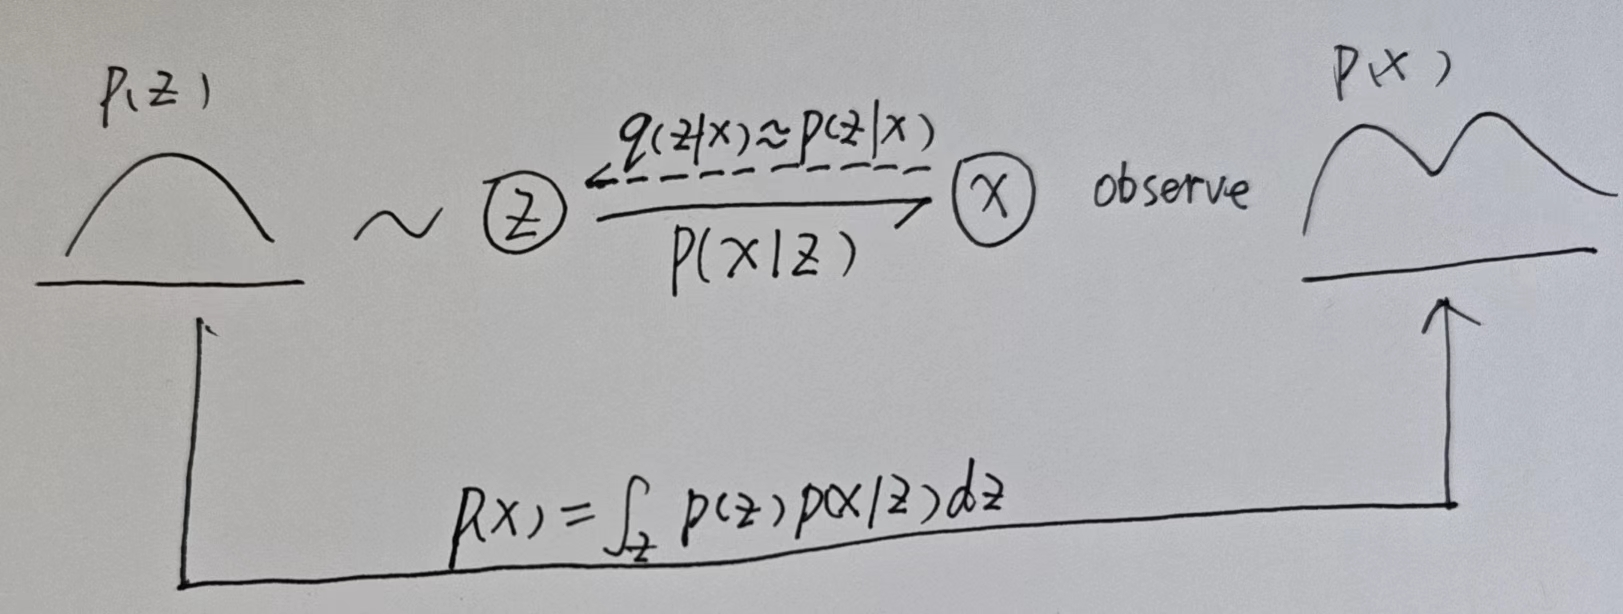

问题：给定样本 $x$，我们如何推断其对应的隐变量 $z$ 呢？

我们可以计算 $p(z|x)$ ：

$$
p(z|x) = \frac{p(z)p(x|z)}{p(x)}\qquad \cdots \qquad (1)
$$

公式(1)中我们有什么？

$p(z)$ 先验分布，我们可以假设其为标准正态分布（其他分布也可以，随便，好计算就行）。

$p(x|z), p(x)$ 两个分布的具体形式未知，但我们可以获取到 $p(x)$ 的信息，我们可以获取到样本 $x$。

也就是说，如果用网络去建模 $p_\theta (x|z)$ ，可以计算得到 $p_\theta (x) = \int_z p(z)p_\theta(x|z) dz$，通过极大似然估计可以估计出最优 

$$
\theta^* = \underset{\theta}{\arg\max}~\mathbb{E}_x [p_\theta(x)] = \underset{\theta}{\arg\max}~\mathbb{E}_x \mathbb{E}_z [p_\theta(x|z)]
$$

有了最优的 $\theta^*$ 之后，显然我们可以计算得到 

$$
p_{\theta^*}(z|x) = \frac{p(z)p_{\theta^*}(x|z)}{p_{\theta^*}(x)} \propto p(z)p_{\theta^*}(x|z)  \qquad \qquad \cdots \qquad \qquad (2)
$$

下面用代码来展示两个简单的例子：

例子一（设置 discrete 为 True or False, GMM 为 True）：

$$
p(z) = \left\{\begin{matrix}
1/5 & z=0\\
4/5 & z=1
\end{matrix}\right.
$$
$$
p(x|z) = \mathcal{N}(\mu_z, I)
$$

例子二（设置 discrete 为 False，GMM 为 False）：
$p(z)$ 为高斯分布，$p(x)$ 为上述的混合高斯分布，$p(x|z)$ 未知，希望成功建模 $p(x|z)$ 使得通过采样得到真实的 $p(x)$。

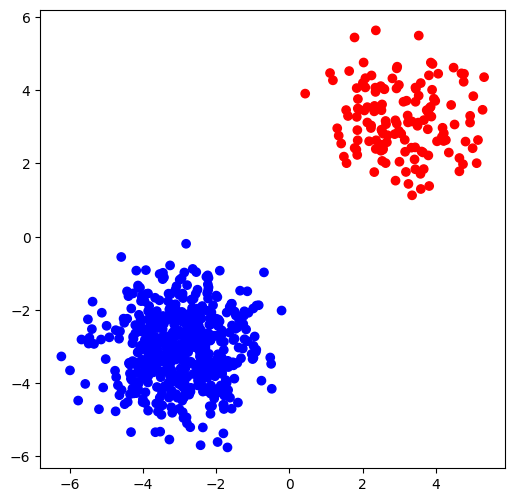

In [1]:
import torch

def sample_z(size: int) -> torch.Tensor:
    z_ = torch.rand(size)
    mask = (z_ < 1 / 5)
    z_[mask] = 0
    z_[~mask] = 1
    return z_

def sample_x1z(z: torch.Tensor) -> torch.Tensor:
    centers = torch.tensor([[3,3],[-3,-3]])
    x_ = torch.randn((z.shape[0], 2))
    x_ += centers[z.long()]
    return x_

def sample_z_new(size: int) -> torch.Tensor:
    return torch.randn(size)

total_sample = 1000
total_z = sample_z(total_sample)
total_x = sample_x1z(total_z)

train_ratio = 0.7
num_train = int(total_sample * train_ratio)
num_eval = total_sample - num_train

total_indices = torch.randperm(total_sample)
train_indices = total_indices[:num_train]
z = total_z[train_indices]
x = total_x[train_indices]

eval_indices = total_indices[num_train:]
eval_z = total_z[eval_indices]
eval_x = total_x[eval_indices]

from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.set_aspect(1)
axes.scatter(x[:,0], x[:,1], c=['r' if tmp == 0 else 'b' for tmp in z])
# axes.set_xlim([-5, 5])
# axes.set_ylim([-5, 5])

In [6]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import math

discrete = False
GMM = False

# 直接假设 p(x|z) 是一个协方差为 I 的高斯分布，网络输出 均值
if not discrete:
    if GMM:
        # 使用连续网络，例子一
        x1z_net = nn.Linear(1, 2)
    else:
        # 使用连续网络，例子二
        x1z_net = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 4))
else:
    if GMM: raise RuntimeError
    # 例子一，离散的输入 z 建议采用离散形式的网络
    x1z_net = nn.Embedding(2, 2)

if GMM:
    lr = 1e-3
else:
    lr = 1e-3
    
optimizer = optim.Adam(x1z_net.parameters(), lr=lr)

total_iter = 10000
bs = 500
per_z_sampled = 200

count_0 = count_1 = 0

progress_bar = tqdm(range(total_iter))

for i in progress_bar:
    if GMM:
        # 例子一
        tmp_z = sample_z(per_z_sampled)
    else:
        # 例子二
        tmp_z = sample_z_new(per_z_sampled)
    
    if not discrete:
        if GMM:
            # 例子一，只建模均值，方差直接采用 I
            mus = x1z_net(tmp_z[:, None])
            var = torch.tensor([[1.0]])
        else:
            # 例子二，同时建模均值和方差，完成 p(z) -> p(x) 的映射
            mu_log_var = x1z_net(tmp_z[:, None])
            mus = mu_log_var[:, :2]
            log_var = mu_log_var[:, 2:]
            var = torch.exp(log_var) + 1e-6
    else:
        # 例子一，只建模均值，方差直接采用 I
        mus = x1z_net(tmp_z.long())
        var = torch.tensor([[1.0]])
        
    indices = torch.randint(0, num_train, (bs,))
    tmp_x = x[indices]

    # ps: 两两向量差值计算快捷方法
    # A: [a, d], B: [b, d]
    # A[:, None, :] - B[None, :, :] 可得到 A，B 矩阵行向量的两两差值，进而可以计算两两距离
    minus = (tmp_x[:, None, :] - mus[None, :, :]) / var[None, :, :]
    pair_dist = torch.sum(minus * minus, dim=-1)
    
    # 计算每个 p(x|z) 的值，2元高斯分布概率密度计算公式
    all_p = 1 / 2 * math.pi * torch.exp(-1/2 * pair_dist) / torch.exp(torch.sum(torch.log(var + 1e-6), dim=-1))[None, :]
        
    # 通过对 z 求期望获得 p(x)
    e_z_x1z = torch.mean(all_p, dim=-1)

    # 通过对 x 求期望得到最后负对数似然
    e_x_log_p_x = torch.mean(-torch.log(e_z_x1z))
    nll = e_x_log_p_x
    if i % 1000 == 0:
        progress_bar.set_postfix(loss=nll.item())
    optimizer.zero_grad()
    nll.backward()
    optimizer.step()

100%|████████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 361.02it/s, loss=1.01]


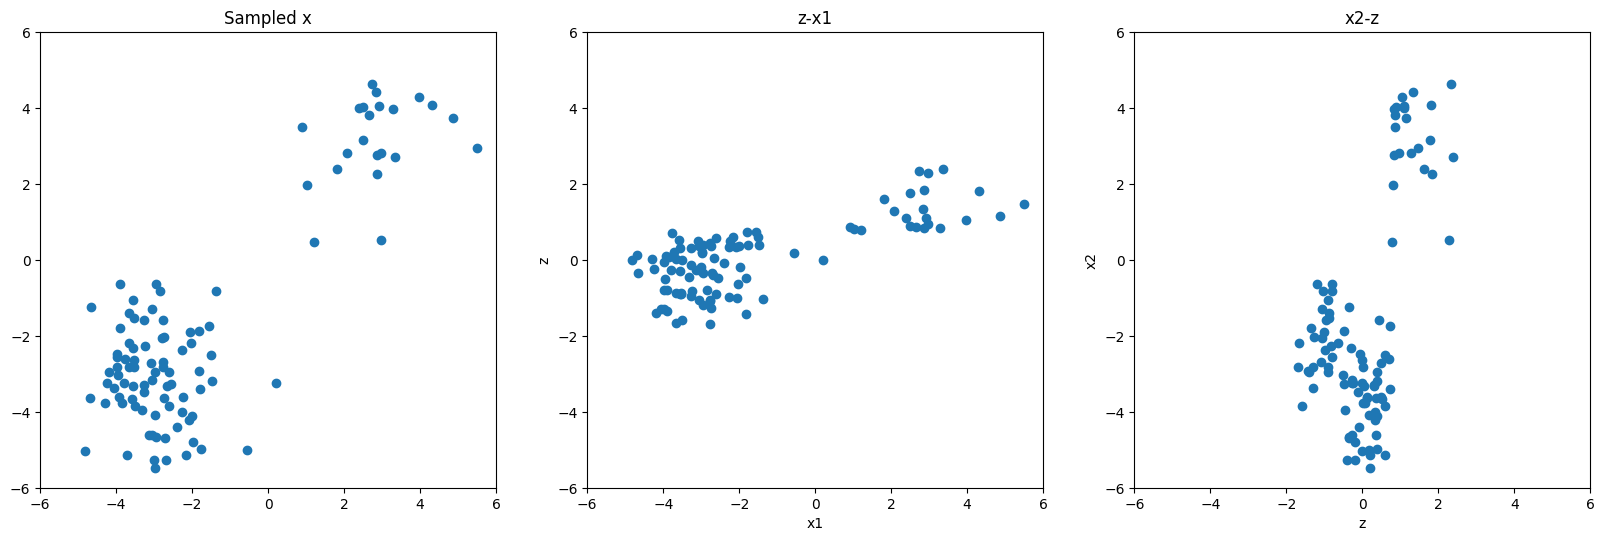

In [20]:
with torch.no_grad():
    if GMM:
        # 例子一，展示拟合出的中心点，并且对测试集做潜变量推断
        if not discrete:
            centers = x1z_net(torch.tensor([[0.0], [1.0]]))
        else:
            centers = x1z_net(torch.tensor([0, 1]))
        print(f"center0: ({centers[0][0].item():.2f}, {centers[0][1].item():.2f})")
        print(f"center1: ({centers[1][0].item():.2f}, {centers[1][1].item():.2f})")
        
        # 做潜变量推断，正确的用绿色，错误的用红色
        tmp_z = sample_z(per_z_sampled)
    
        zero_mask = (tmp_z < 0.5)
        
        if not discrete:
            mus = x1z_net(tmp_z[:, None])
        else:
            mus = x1z_net(tmp_z.long())
            
        # 计算两两之间距离
        sq_mus = torch.sum(mus * mus, dim=-1)
        indices = torch.randint(0, num_train, (bs,))
        tmp_x = eval_x
        sq_x = torch.sum(tmp_x * tmp_x, dim=-1)
        pair_dist = sq_x[:, None] - 2 * tmp_x @ mus.T + sq_mus[None, :]
        # 计算每个 p(x|z) 的值
        all_p = 1 / 2 * math.pi * torch.exp(-1/2 * pair_dist)
    
        p_z_0 = torch.sum(all_p[:, zero_mask], dim=-1) * torch.sum(zero_mask) / per_z_sampled
        p_z_1 = torch.sum(all_p[:, ~zero_mask], dim=-1) * torch.sum(~zero_mask) / per_z_sampled
        pre_z = (p_z_0 < p_z_1)
        accurate = pre_z.float() - eval_z
        fig, axes = plt.subplots(1, 1, figsize=(6, 6))
        axes.set_aspect(1)
        axes.scatter(eval_x[:,0], eval_x[:,1], c=['g' if tmp == 0 else 'r' for tmp in accurate])
    else:
        # 例子二，采100个样本点试试水，看看是否符合 p(x)
        num_sample = 100
        z = sample_z_new(num_sample)
        mu_log_var = x1z_net(z[:, None])
        mus = mu_log_var[:, :2]
        log_var = mu_log_var[:, 2:]
        std = torch.sqrt(torch.exp(log_var))

        epsilon = torch.randn([num_sample, 2])

        out_x = mus + std * epsilon
        
        fig, axes_list = plt.subplots(1, 3, figsize=(20, 6))
        ax1, ax2, ax3 = axes_list
        ax1.set_aspect(1)
        ax2.set_aspect(1)
        ax3.set_aspect(1)
        ax1.set_xlim([-6,6])
        ax1.set_ylim([-6,6])
        ax2.set_xlim([-6,6])
        ax2.set_ylim([-6,6])
        ax3.set_xlim([-6,6])
        ax3.set_ylim([-6,6])
        
        ax1.scatter(out_x[:,0], out_x[:,1])
        ax1.set_title('Sampled x')
        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        
        # Plot z vs. x1
        ax2.scatter(out_x[:, 0].detach().numpy(), z.detach().numpy(), label='x1 from z')
        ax2.set_title('z-x1')
        ax2.set_xlabel('x1')
        ax2.set_ylabel('z')
        
        # Plot z vs. x2
        ax3.scatter(z.detach().numpy(), out_x[:, 1].detach().numpy(), label='x2 from z')
        ax3.set_title('x2-z')
        ax3.set_xlabel('z')
        ax3.set_ylabel('x2')
    

通过上面的例子我们看到，我们确实可以通过拟合 $p(x|z)$ 的方式实现潜变量推断或者从一个先验分布变换到另一个已知数据分布（生成式）。

但是我们可以看到的是：当潜变量是连续变量时，采用公式（2）做潜变量推断十分困难；对于更难的数据分布，通过这种无配对的 $(x, z)$ 去学习 $p(x|z)$ 将会更加困难，网络需要遍历更加复杂的空间来完成 $p(x|z)$ 的构建。